### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import os
pd.pandas.set_option('display.max_columns', None)

from scipy import stats
from sklearn.linear_model import LassoCV
from datetime import datetime, timedelta

from plotly import express as px
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Video, Image

import matplotlib
from matplotlib.colors import LinearSegmentedColormap

import shap
from BorutaShap import BorutaShap
from lightgbm import LGBMRegressor

os.chdir('C:/Users/Xavi/Desktop/Memorable/modules')

import lasso_model_library as lasso
import ca_plots as ca_plt

os.chdir('C:/Users/Xavi/Desktop/Memorable/Projects/Bayer_actron_umbrella_logo')

¡Lasso model library imported succesfully!


All libraries were successfully imported! -> numpy, pandas, os, datetime from datetime, seaborn, matplotlib.
LassoCV model was saccessfully imported!


----
### Loading data




#### USAR BAYER Y COMPETITORS . CSV

In [1]:
#df = pd.read_csv(os.path.join('data/bayer.csv'))
#df[['asset_id', 'ad_id','carrousel_position','filename']].drop_duplicates(subset=['ad_id', 'carrousel_position'])

In [2]:
df_annotation = pd.read_csv('data/annotation.csv')
df_annotation = df_annotation.rename(columns={'assetId':'asset_id'})

In [4]:
brand = input("choose 'bayer' or 'competitors': ")
if brand=='bayer':
    #df = pd.read_csv(os.path.join('data/bayer.csv'))
    df = pd.read_csv(os.path.join('data/bayer_branding_correction.csv'))
    df.tag_name = df.tag_name.astype(str)
    df.tag_name = df.tag_name.str.lower()
    df['unique_asset_id'] = [hash((x, y)) for x, y in zip(df['ad_id'], df['carrousel_position'])]
    df['weight'] = 1
    for i in range(len(df)):
        if df.carrousel_position[i]>0:
            df.weight[i] = 1/(1+df.carrousel_position[i])**2
    
    #---------------------FILTERING low impressions at 5%----------------------
    df = df.loc[df.impressions > df.impressions.quantile(0.05)]

    #---------------------CREATING METRICS IF IS NECESSARY------------------------
    df['ctr'] = df.clicks.values / df.impressions.values
    df['cpc'] = df.spend.values / df.clicks.values
    df['vtr'] = df.video_views.values / df.impressions.values

    df.loc[df['clicks'] == 0, 'cpc'] = 0
    df.loc[df['impressions'] == 0, 'ctr'] = 0
    df.loc[df['impressions'] == 0, 'vtr'] = 0

    df['ctr'] = df['ctr']*100
    df['vtr'] = df['vtr']*100

    #df = df.loc[df.brand_name=='Actron Argentina']
    print(f'You choose these brands: {df.brand_name.unique()}')
elif brand=='competitors':
    df = pd.read_csv(os.path.join('data/competitors.csv'))
    df.tag_name = df.tag_name.astype(str)
    df.tag_name = df.tag_name.str.lower()
    df = df.loc[df.asset_id.isin(df_annotation.asset_id)]
    print(f"You will working with these brands: {df.brand_name.unique()}")
else:
    print("Error")

You choose these brands: ['Actron Argentina' 'Redoxitos Argentina']


In [5]:
df['tag_name'] = df['tag_name'].replace('logo: primary', 'brand logo')
df['tag_name'] = df['tag_name'].replace('logo: in pack', 'brand logo in product')
df['tag_name'] = df['tag_name'].replace('company logo', 'company logo')
df['tag_name'] = df['tag_name'].replace('logo: always on', 'brand logo always on')

In [6]:
print(f"before drop de tag types, the number of unique tags: {df.tag_name.nunique()}")
#--------------FILTERING USELESS TAG TYPES---------------------------------    
df = df.loc[df.tag_type!='TEXT']
df = df.loc[df.tag_type!='SUPER_NOUN']
df = df.loc[df.tag_type!='SUPER_ADJ']
df = df.loc[df.tag_type!='SUPER_VERB']
df = df.loc[df.tag_type!='COLORFULNESS']
df = df.loc[df.tag_type!='BRIGHTNESS']
df = df.loc[df.tag_type!='PERSON_TEMPORAL_SEC']
df = df.loc[df.tag_type!='HAS_PROMO']
df = df.loc[df.tag_type!='HAS_CTA']
df = df.loc[df.tag_type!='CONTRAST']
df = df.loc[df.tag_type!='LOGO_TEMPORAL_SEC']
df = df.loc[df.tag_type!='LOGO_SPATIAL']
df = df.loc[df.tag_type!='LOGO_TEMPORAL_PCT']
df = df.loc[df.tag_type!='LOGO']
df = df.loc[df.tag_type!='AESTHETICS']
df = df.loc[df.tag_type!='COLOR']
df = df.loc[df.tag_type!='LABEL']

#df = df.loc[df.tag_type!='HAS_PERSON']
#df = df.loc[df.tag_type!='TEXT_SALIENCY']
#df = df.loc[df.tag_type!='TEXT_COVERAGE'] 


#----------SETTING CONFIDENCE-----------------------
df['confidence'] = df['confidence'].apply(lambda x: x/100 if x > 1 else x)
    
df = df.loc[df.confidence>0.9]
df = df.reset_index(drop=True)

print(f"number of assets: {df.asset_id.nunique()}")
print(f"after drop de tag types, the number of unique tags: {df.tag_name.nunique()}")

before drop de tag types, the number of unique tags: 1558
number of assets: 124
after drop de tag types, the number of unique tags: 57


In [7]:
df.drop_duplicates(subset=['tag_name']).tag_type.value_counts()

FACE                      16
OBJECT                    14
BIGGEST_TEXT_POSITION      8
manual_logo                4
LOGO_SALIENCY              3
PERSON_COVERAGE            3
TEXT_COVERAGE              3
TEXT_SALIENCY              3
LENGTH_OF_VISIBLE_TEXT     2
HAS_PERSON                 1
Name: tag_type, dtype: int64

In [ ]:
print(f"ads: {df.ad_id.nunique()} , different filenames: {df.asset_id.nunique()}")
print(f"videos: {df.loc[df.file_type=='VIDEO'].asset_id.nunique()}, images: {df.loc[df.file_type=='IMAGE'].asset_id.nunique()}")

In [9]:
metric = input("Set the metric to be analyzed: ")
metric = metric.replace("Set the metric to be analyzed: ", "")

if metric=='vtr':
    df = df.loc[df.file_type=='VIDEO']
elif metric=='adrecallScore':
    df = df.loc[df.adrecallScore!='no_data']
    df.adrecallScore = df.adrecallScore.astype(float)
elif metric=='bai':
    df = df.loc[df.bai!='no_data']
    df.bai = df.bai.astype(float)
    df = df.loc[df.bai!=0]
    
    
print("-------After choose the metric-------")
#print(f"ads: {df.ad_id.nunique()} , creatives: {df.asset_id.nunique()}")
#print(f"videos: {df.loc[df.file_type=='VIDEO'].asset_id.nunique()}, images: {df.loc[df.file_type=='IMAGE'].asset_id.nunique()}")

-------After choose the metric-------


---
### Processing target metric

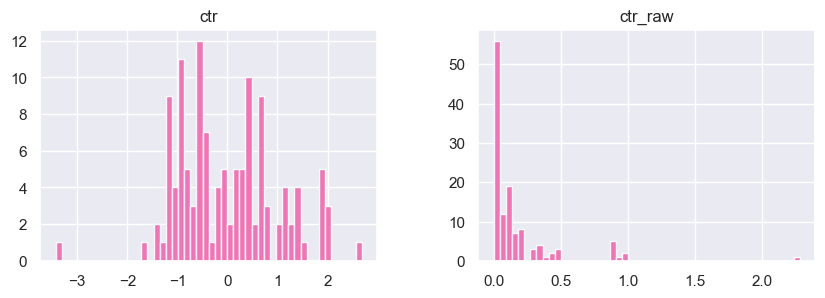

In [10]:
# Parameters ----------------------------------------------------------
index_col = ['asset_id']
norm_metric = True
print_metric = True
transform_type = 'log'
lmbda = 0
transform_coef = 1e-3
#------------------------------------------------------------------------------------

metrics = lasso.process_metrics(df, index_col, metric, transform_type, transform_coef, lmbda=lmbda, norm_metric=norm_metric,
                                print_metric=print_metric, figsize=(10,3))

### Preprocessing data

In [11]:
# PARAMETROS MODIFICABLES ----------------------------------------------------------
tag_type_col = 'tag_type'
tag_name_col = 'tag_name'
tag_id_col = 'tag_id'

# Genero tabla dinamica
tags = (df.pivot_table(index=index_col, columns=[tag_type_col, tag_name_col],
                        values=tag_id_col, aggfunc='count').fillna(0) > 0).\
                        astype(int).\
                        replace([np.inf, -np.inf], 0)                          

tags_freq = tags.sum(0).reset_index().rename(columns={'tag_type':'tag_group',
                                                      'tag_name':'tag',
                                                       0:'usage_frequency'})

tags_aux = tags.copy()
tags_aux.columns = tags_aux.columns.droplevel()
tags_aux = tags_aux.loc[:,~tags_aux.columns.duplicated()]

print(f"Number of assets: {len(tags_aux)}")
print(f"Number of tags: {len(tags_aux.columns)}")
tags_aux.head(2)

Number of assets: 124
Number of tags: 57


tag_name,biggest_text_position_bottom,biggest_text_position_bottom_left,biggest_text_position_bottom_right,biggest_text_position_center,biggest_text_position_left,biggest_text_position_top,biggest_text_position_top_left,biggest_text_position_top_right,0-9,10-25,25-34,35-54,angry,calm,confused,fear,female,happy,latino,male,middle eastern,sad,surprised,white,has_person_true,length_of_visible_text_long,length_of_visible_text_medium,logo_saliency_high,logo_saliency_low,logo_saliency_medium,bicycle,clothing,football,footwear,girl,glasses,human face,laptop,man,office building,plant,plastic bag,poster,tree,person_coverage_large,person_coverage_medium,person_coverage_small,text_coverage_large,text_coverage_medium,text_coverage_small,text_saliency_high,text_saliency_low,text_saliency_medium,brand logo,brand logo always on,brand logo in product,company logo
asset_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
01GQ3BJ809S99TFGZ5QH4HPFRW,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,1,1,1,0,1,1,1,1,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,1
01GQ3BJ80B3QV5GAASQ7E4ZW0W,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,1,1,1,0,1,0,1,1,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,1


---------
### Auxiliar cells

In [8]:
from sklearn.model_selection import train_test_split

X = tags_aux.copy()
y = metrics[metric]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(93, 57) (31, 57) (93,) (31,)


In [9]:
df_weight = df[['asset_id', 'weight']].groupby('asset_id').first().iloc[:,0].reset_index()
weights_train = df_weight.loc[df_weight.asset_id.isin(X_train.reset_index().asset_id.values)].groupby('asset_id').first().iloc[:,0]

model = LGBMRegressor(boosting_type='gbdt',
                              max_depth=3,
                              n_estimators=5,
                              learning_rate=0.4,
                              objective='mse',
                              n_jobs=-1)

model.fit(X=X_train, y=y_train, sample_weight=weights_train)

explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)

from sklearn.metrics import r2_score

print(r2_score(y_train, model.predict(X_train)))
print(r2_score(y_test, model.predict(X_test)))

0.20199314028389237
0.017625103992829905


In [ ]:
import statsmodels.api as sm

y = metrics[metric]
X = tags_aux

ols = sm.OLS(y, sm.add_constant(X)).fit()
display(ols.summary())

----------------------
### Shap

In [8]:
weights = df[['asset_id', 'weight']].groupby('asset_id').first().iloc[:,0]

model = LGBMRegressor(boosting_type='gbdt',
                              max_depth=3,
                              n_estimators=5,
                              learning_rate=0.4,
                              objective='mse',
                              n_jobs=-1, random_state=0)

model.fit(X=tags_aux, y=metrics[metric], sample_weight=weights)

explainer = shap.Explainer(model, tags_aux)
shap_values = explainer(tags_aux)

In [9]:
## Genero tabla dinamica
#df_actron = df.loc[df.brand_name=='Actron Argentina']
#tags_actron = (df_actron.pivot_table(index=index_col, columns=[tag_type_col, tag_name_col],
#                        values=tag_id_col, aggfunc='count').fillna(0) > 0).\
#                        astype(int).\
#                        replace([np.inf, -np.inf], 0)                          
#
#tags_actron_freq = tags_actron.sum(0).reset_index().rename(columns={'tag_type':'tag_group',
#                                                      'tag_name':'tag',
#                                                       0:'usage_frequency'})
#
#tags_actron_aux = tags_actron.copy()
#tags_actron_aux.columns = tags_actron_aux.columns.droplevel()
#tags_actron_aux = tags_actron_aux.loc[:,~tags_actron_aux.columns.duplicated()]
#
#print(f"Number of tags_actron: {len(tags_actron_aux)}")

Number of tags_actron: 61


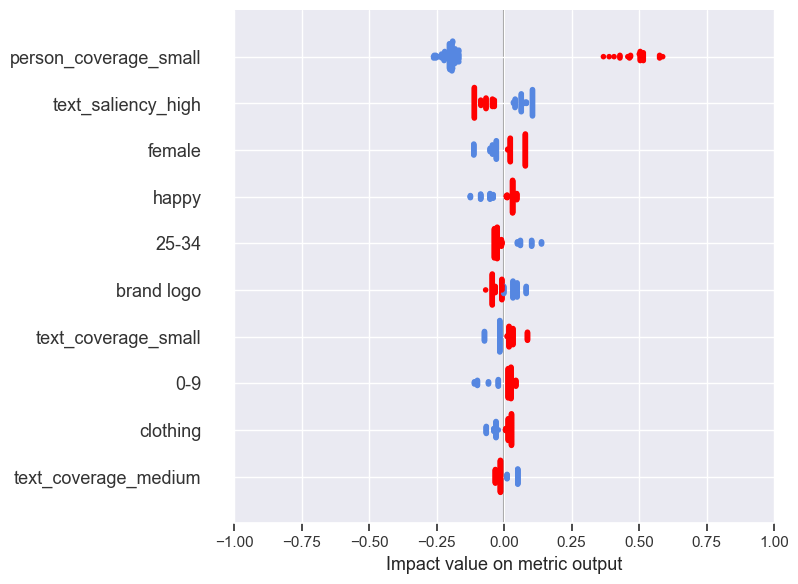

In [108]:
#colors = [(204/255, 0, 0), (0, 0, 204/255)]
colors = [(1, 0, 0), (86/255, 135/255, 225/255)]
n_bin = 100
cmap_parameter = LinearSegmentedColormap.from_list(name='name_list', colors=colors, N=n_bin)
#plt.figure(facecolor='white')
#plt.style.use('seaborn-whitegrid')
shap.summary_plot(shap_values, tags_aux, plot_type="dot", max_display=10, plot_size=(8,6), show=False, cmap=cmap_parameter, color_bar=False)
plt.xlim(-1,1)
plt.xlabel('Impact value on metric output')
plt.savefig(f'Img/beeswarm_for_{metric}.png')
plt.show()

In [30]:
print(f"Before: {shap_values.values.shape}")

#This is a code for hide tags in a beeswarm chart that is above. 
# DON'T RUN THIS CELL IF YOU DON'T HIDE ANY TAG
list_columns = ['woman', 'fade in', 'hair touching']
list_index = []
for i,e in enumerate(shap_values.feature_names):
    if e in list_columns:
        list_index.append(i)

tags_aux = tags_aux.drop(columns=list_columns)

for i in list_index:
    del shap_values.feature_names[i]

shap_values.values = np.delete(shap_values.values, list_index, axis=1)
shap_values.data = np.delete(shap_values.data, list_index, axis=1)

print(f"After: {shap_values.values.shape}")

Before: (87, 386)
After: (87, 383)


In [104]:
#shap.plots.bar(shap_values, neg_color='#cc0000', pos_color='#00cc00', max_display=10, show_sum_of_features=False, edge_color='black')

Modificaciones en _bar.py:
- add parameter: show_sum_of_features
- add parameter: edge_color

En boruta sharp:
#from sklearn.datasets import load_breast_cancer, load_boston

### Calculating score values 

In [169]:
tags_freq = tags.sum(0).reset_index().rename(columns={'tag_type':'tag_group', 'tag_name':'tag', 0:'usage_frequency'})
tags_freq["usage_frequency"] = tags_freq.usage_frequency / len(tags)

tags_score_per_asset = pd.DataFrame(shap_values.values, columns=shap_values.feature_names)
tags_score_per_asset['asset_id'] = tags_aux.reset_index().asset_id.copy()

list_of_mean_tags = []
for col in tags_aux.columns:
    tag_mean = tags_aux[col].loc[tags_aux[col]==1].reset_index().drop(columns={col}).merge(tags_score_per_asset[[col, 'asset_id']], on='asset_id', how='inner').mean()[0]
    list_of_mean_tags.append(tag_mean)

data = {'tag': tags_aux.columns, 'tag_mean': list_of_mean_tags}

df_sign = pd.DataFrame(data)

shap_results = pd.DataFrame({'score':tags_score_per_asset.drop(columns={'asset_id'}).abs().mean()})
shap_results = shap_results.reset_index().rename(columns={'index':'tag'})

for i,value in enumerate(df_sign.tag_mean):
    if value<0:
        shap_results['score'][i] = shap_results['score'][i]*(-1)


shap_results = pd.merge(shap_results, tags_freq, how='inner', on='tag')
shap_results['period'] = 'all'
shap_results['metric'] = metric

shap_results.head()

,tag,score,tag_group,usage_frequency,period,metric
0,biggest_text_position_bottom,0.0,BIGGEST_TEXT_POSITION,0.145161,all,ctr
1,biggest_text_position_bottom_left,0.0,BIGGEST_TEXT_POSITION,0.024194,all,ctr
2,biggest_text_position_bottom_right,0.0,BIGGEST_TEXT_POSITION,0.016129,all,ctr
3,biggest_text_position_center,0.0,BIGGEST_TEXT_POSITION,0.161290,all,ctr
4,biggest_text_position_left,0.0,BIGGEST_TEXT_POSITION,0.032258,all,ctr


In [ ]:
#shap_results.to_csv(f'results/results_for_{metric}.csv', index=False)

In [ ]:
shap_values.values[0] = shap_results.score.values
shap.plots.bar(shap_values[0], neg_color='#cc0000', pos_color='#00cc00', max_display=10, show_sum_of_features=False, edge_color='black')

-------------
### Boruta shap

In [12]:
%%time
model = LGBMRegressor(boosting_type='gbdt',
                              max_depth=3,
                              n_estimators=5,
                              learning_rate=0.4,
                              objective='mse',
                              n_jobs=-1, random_state=0)

# Feature selection with BorutaShap for regression
Feature_Selector = BorutaShap(model=model,   
                              importance_measure='shap', 
                              classification=False)

Feature_Selector.fit(X=tags_aux, y=metrics[metric].fillna(0), n_trials=200, random_state=2)

#Feature_Selector.accepted
#Feature_Selector.shap_values

# Select the best feature subset
X_fil = Feature_Selector.Subset()

  0%|          | 0/200 [00:00<?, ?it/s]

3 attributes confirmed important: ['brand logo', '0-9', 'text_saliency_high']
52 attributes confirmed unimportant: ['man', 'tree', 'white', 'person_coverage_large', '35-54', 'calm', 'fear', 'poster', 'angry', 'sad', 'length_of_visible_text_medium', 'biggest_text_position_bottom_right', 'confused', 'glasses', 'clothing', 'human face', 'has_person_true', 'surprised', 'logo_saliency_high', 'laptop', 'biggest_text_position_left', 'biggest_text_position_bottom_left', 'footwear', 'happy', 'company logo', 'text_coverage_large', 'biggest_text_position_center', 'latino', 'girl', 'female', 'logo_saliency_low', 'bicycle', 'male', 'text_coverage_small', 'biggest_text_position_top_right', 'text_coverage_medium', '25-34', 'middle eastern', 'biggest_text_position_top', 'logo_saliency_medium', 'office building', 'plant', 'brand logo always on', '10-25', 'biggest_text_position_top_left', 'football', 'text_saliency_low', 'plastic bag', 'person_coverage_medium', 'text_saliency_medium', 'length_of_visible

In [ ]:
# Feature importance plot
Feature_Selector.plot(which_features='accepted', figsize=(10,6), X_size=10)

In [111]:
important_confirmed_attributes = Feature_Selector.accepted + Feature_Selector.tentative
print(important_confirmed_attributes)

['brand logo', 'text_saliency_high', '0-9', 'person_coverage_small', 'brand logo in product']


In [112]:
import statsmodels.api as sm

y = metrics[metric]
X = tags_aux[important_confirmed_attributes]

ols = sm.OLS(y, tags_aux[important_confirmed_attributes]).fit()
display(ols.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    ctr   R-squared (uncentered):                   0.181
Model:                            OLS   Adj. R-squared (uncentered):              0.147
Method:                 Least Squares   F-statistic:                              5.275
Date:                Mon, 30 Jan 2023   Prob (F-statistic):                    0.000206
Time:                        10:36:23   Log-Likelihood:                         -163.04
No. Observations:                 124   AIC:                                      336.1
Df Residuals:                     119   BIC:                                      350.2
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
brand logo                0.3743      0.167      2.240      0.027       0.043       0.705
text_saliency_high        0.2242      0.161      1.393      0.166      -0.095       0.543
0-9                      -0.4843      0.206     -2.345      0.021      -0.893      -0.075
person_coverage_small    -0.4805      0.129     -3.739      0.000      -0.735      -0.226
brand logo in product     0.2841      0.161      1.762      0.081      -0.035       0.603
==============================================================================
Omnibus:                        4.470   Durbin-Watson:                   2.073
Prob(Omnibus):                  0.107   Jarque-Bera (JB):                5.507
Skew:                           0.126   Prob(JB):                       0.0637
Kurtosis:                       4.001   Cond. No.                         3.50
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [113]:
weights = df[['asset_id', 'weight']].groupby('asset_id').first().iloc[:,0]

model = LGBMRegressor(boosting_type='gbdt',
                              max_depth=3,
                              n_estimators=5,
                              learning_rate=0.4,
                              objective='mse',
                              n_jobs=-1, random_state=0)

model.fit(X=tags_aux[important_confirmed_attributes], y=metrics[metric], sample_weight=weights)

explainer = shap.Explainer(model, tags_aux[important_confirmed_attributes])
shap_values = explainer(tags_aux[important_confirmed_attributes])

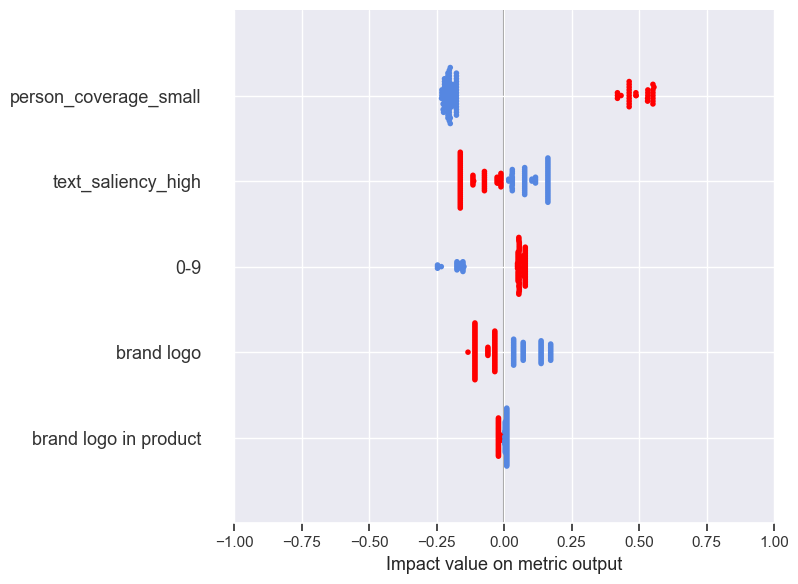

In [114]:
#colors = [(204/255, 0, 0), (0, 0, 204/255)]
colors = [(1, 0, 0), (86/255, 135/255, 225/255)]
n_bin = 100
cmap_parameter = LinearSegmentedColormap.from_list(name='name_list', colors=colors, N=n_bin)
#plt.figure(facecolor='white')
#plt.style.use('seaborn-whitegrid')
shap.summary_plot(shap_values, tags_aux[important_confirmed_attributes], plot_type="dot", max_display=5, plot_size=(8,6), show=False, cmap=cmap_parameter, color_bar=False)
plt.xlim(-1,1)
plt.xlabel('Impact value on metric output')
#plt.savefig(f'Img/beeswarm_for_{metric}.png')
plt.show()

------------------

### Significant tests

In [ ]:
results = shap_results.copy()

results["Score sign"] = results["score"].apply(lambda x: "Positive" if x > 0 else "Negative")
results.rename(columns={"score":"Score", "metric":"Metric", "tag_group":"Tag type", "tag":"Tag name"}, inplace=True)
results["Tag name"] = results["Tag name"].apply(lambda x: x.replace("excessive ice", "icee"))
results.head(5)

In [ ]:
def mean_difference(tag_group, tag, metric, sufix):
    ads_with_tag = tags.index[tags[tag_group, tag]==1]
    mean_with =    metrics.loc[ metrics.index.isin(ads_with_tag), metric+sufix].mean()
    mean_without = metrics.loc[~metrics.index.isin(ads_with_tag), metric+sufix].mean()
    return mean_with / mean_without - 1
   
results["Tag impact"] = results.apply(lambda x: mean_difference(x["Tag type"], x["Tag name"], x["Metric"], ""), axis=1)
#results["Tag impact trans"] = results.apply(lambda x: mean_difference(x["Tag type"], x["Tag name"], x["Metric"], ""), axis=1)
results

In [ ]:
px.box(results, x="Metric", y="Tag impact", color="Score sign", points="all", title="Lasso score distribution by metric")

In [ ]:
# mann whitney U test mannwhitneyu
from scipy.stats import ttest_ind
for metric in results["Metric"].unique():
    tmp = results[results["Tag impact"].notna()]
    print(metric)
    res= ttest_ind(
            tmp[(tmp["Score sign"]=="Negative") & (tmp["Metric"]==metric)]["Tag impact"],
            tmp[(tmp["Score sign"]=="Positive") & (tmp["Metric"]==metric)]["Tag impact"],
            alternative="less"
        )
    mean_negative = tmp[(tmp["Score sign"]=="Negative") & (tmp["Metric"]==metric)]["Tag impact"].mean()
    mean_positive = tmp[(tmp["Score sign"]=="Positive") & (tmp["Metric"]==metric)]["Tag impact"].mean()
    # print mean difference
    print(f"{res.pvalue} {abs(mean_positive - mean_negative)/abs(mean_negative)*100:.1f}%")

In [ ]:
#ca_plt.gg_scatterplot_install()

In [ ]:
#ca_plt.gg_scatterplot_2(shap_results_filter, metric, period='all', y_max=shap_results_filter.score.max()+0.01, y_min=shap_results_filter.score.min()-0.01, tags_plot=[],
#                        y_title='Estimated\nregression\ncoefficient',
#                        x_title='Usage frequency',n_tags=15,save=False,filename=f'Img/scatterplot_for_{metric}.png',
#                        width=900,height=600,plot=True, label_size=4, freq=0.5,y_ext=0.02,
#                        symbol_size=3,
#                        metrics_positive=['ctr','vvr','likes','shares','comments','vtr', 'BAI', 'MEMORABILITY_ADRECALLPROB', 'adrecallScore'],
#                        metrics_negative=['cpc','cpm','cpmr','cpv'],
#                        colors=[],legend_labels=[],shapes=[20,17,8,18,12,13,9,1,2])